# Task 2 — Linear Filters & Convolution

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float32

# ====== CONFIG ======

In [2]:
IMG_PATH = "../img/car.jpg"   
SAVE_OUTPUTS = True
OUT_DIR = "task2_outputs"
BORDER = "reflect"            

os.makedirs(OUT_DIR, exist_ok=True)

# ---- Load image -> grayscale float32 in [0, 1] ----

In [3]:
im = io.imread(IMG_PATH)
if im.ndim == 3:
    im = color.rgb2gray(im)
im = img_as_float32(im)

# ---- Padding util to match border behavior ----

In [4]:
def pad2d(x, pad_y, pad_x, mode="reflect"):
    if mode == "constant":
        return np.pad(x, ((pad_y, pad_y), (pad_x, pad_x)), mode="constant", constant_values=0.0)
    if mode == "replicate":
        return np.pad(x, ((pad_y, pad_y), (pad_x, pad_x)), mode="edge")
    # default to reflect (not reflect101)
    return np.pad(x, ((pad_y, pad_y), (pad_x, pad_x)), mode="reflect")

# ---- Manual 2D convolution (single-channel) ----

In [5]:
def conv2d_manual(img, kernel, border="reflect"):
    ky, kx = kernel.shape
    assert ky % 2 == 1 and kx % 2 == 1, "Kernel size must be odd."
    py, px = ky // 2, kx // 2
    k = np.flipud(np.fliplr(kernel)).astype(np.float32)  # true convolution (flip both axes)
    padded = pad2d(img, py, px, mode=border)
    H, W = img.shape
    out = np.zeros_like(img, dtype=np.float32)
    for y in range(H):
        ys = y
        for x in range(W):
            xs = x
            patch = padded[ys:ys+ky, xs:xs+kx]
            out[y, x] = np.sum(patch * k, dtype=np.float32)
    return out

# ---- Kernels ----

In [6]:
def box_kernel(k):
    k = int(k)
    K = np.ones((k, k), dtype=np.float64) / (k*k)
    return K

def gaussian_kernel_2d(sigma, k=None):
    # pick size ≈ 6σ rounded to odd
    if k is None:
        k = int(np.ceil(6*sigma)) | 1
    ax = np.arange(-(k//2), k//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    K = np.exp(-(xx**2 + yy**2)/(2*sigma**2))
    K /= K.sum()
    return K


# ---- OpenCV border map ----

In [7]:
def cv2_border_from_str(s):
    return {
        "reflect": cv2.BORDER_REFLECT,
        "constant": cv2.BORDER_CONSTANT,
        "replicate": cv2.BORDER_REPLICATE
    }.get(s, cv2.BORDER_REFLECT)

# ---- Run experiments ----

[box3] MAE=0.000005 | Max|diff|=0.014874 | kernel (3, 3)


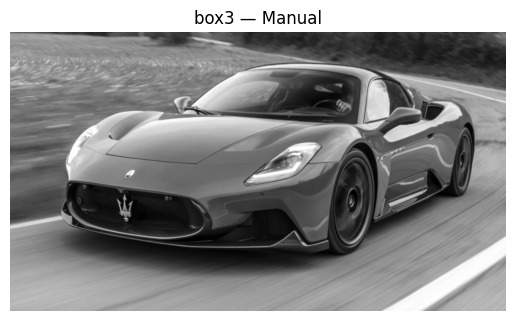

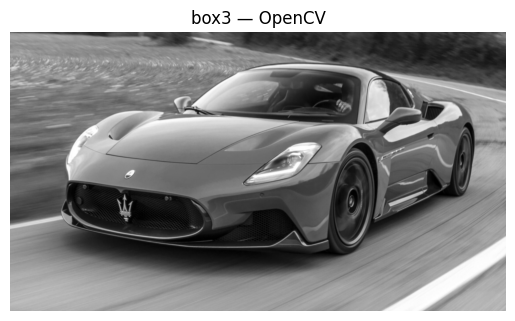

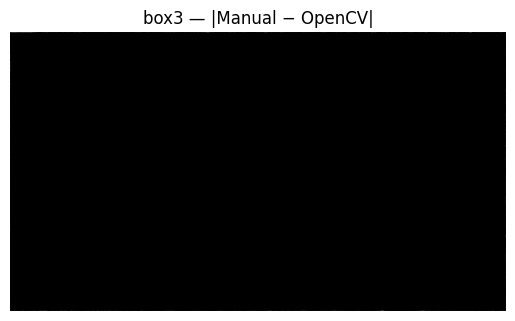

[box5] MAE=0.000008 | Max|diff|=0.019375 | kernel (5, 5)


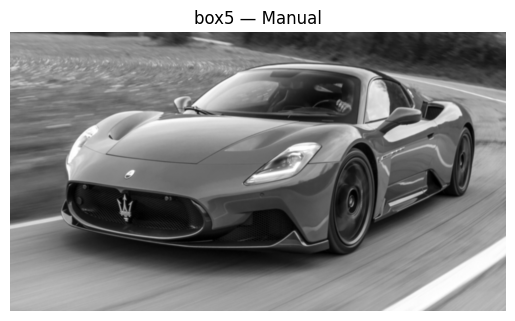

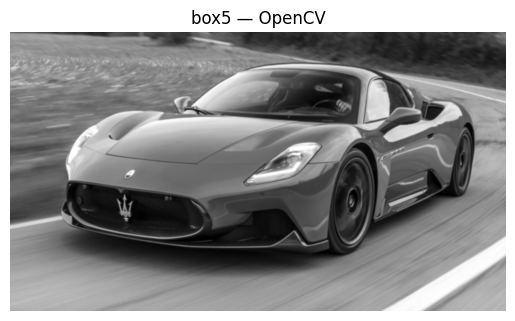

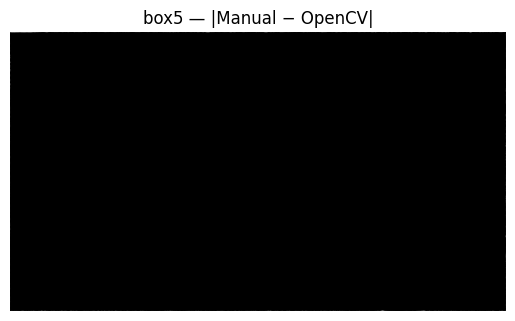

[gauss_sigma1] MAE=0.000005 | Max|diff|=0.013603 | kernel (7, 7)


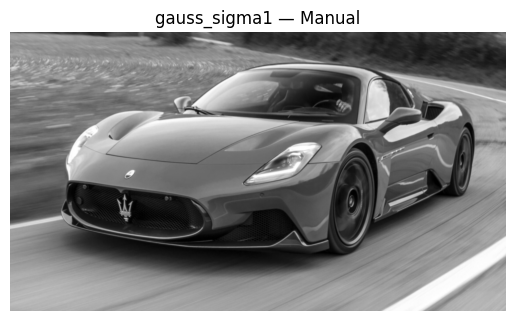

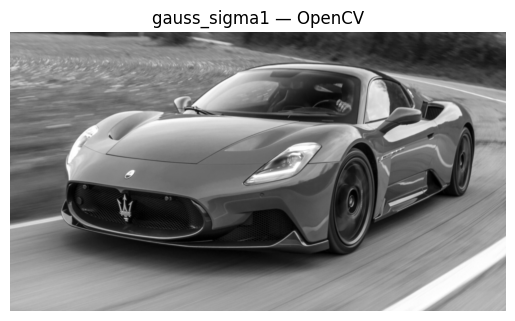

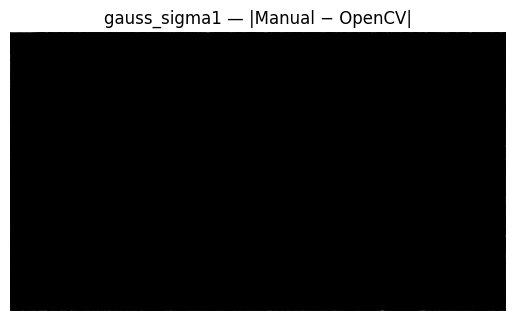

[gauss_sigma2] MAE=0.000009 | Max|diff|=0.017199 | kernel (13, 13)


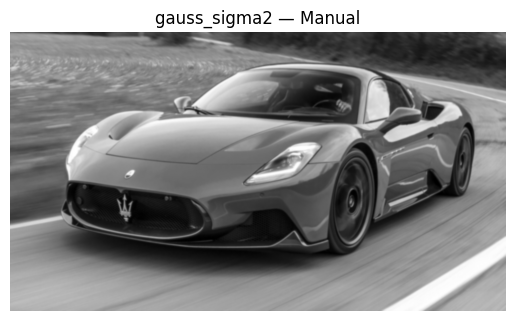

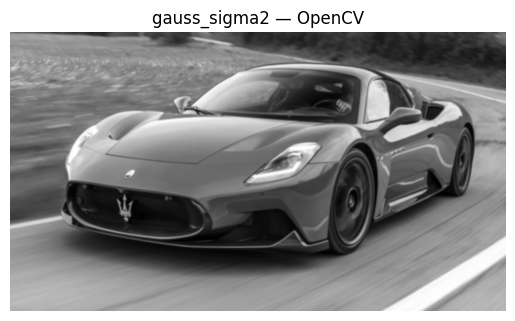

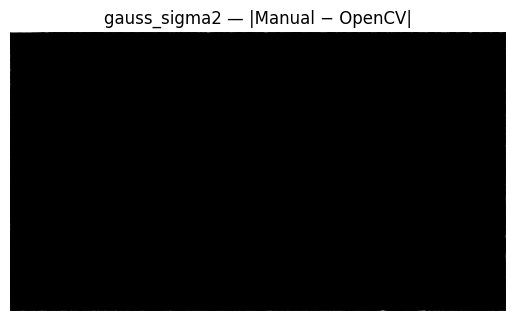

In [8]:
cases = [
    ("box3", box_kernel(3)),
    ("box5", box_kernel(5)),
    ("gauss_sigma1", gaussian_kernel_2d(1.0)),
    ("gauss_sigma2", gaussian_kernel_2d(2.0)),
]

def compare_and_show(name, k):
    # manual
    man = conv2d_manual(im, k, border=BORDER)
    # OpenCV reference (cv2.filter2D expects kernel not flipped; but it implements correlation.
    # We flipped in manual to perform true convolution; to match outputs, pass flipped kernel to cv2.)
    k_flipped = np.flipud(np.fliplr(k)).astype(np.float32)
    ref = cv2.filter2D(im, ddepth=-1, kernel=k_flipped, borderType=cv2_border_from_str(BORDER))

    # difference metrics
    mae = float(np.mean(np.abs(man - ref)))
    mxd = float(np.max(np.abs(man - ref)))

    print(f"[{name}] MAE={mae:.6f} | Max|diff|={mxd:.6f} | kernel {k.shape}")
    
    # visualize (each on its own figure as required)
    plt.figure()
    plt.imshow(man, cmap="gray")
    plt.title(f"{name} — Manual")
    plt.axis("off")
    if SAVE_OUTPUTS:
        plt.savefig(os.path.join(OUT_DIR, f"{name}_manual.png"), bbox_inches="tight", pad_inches=0)
    plt.show()

    plt.figure()
    plt.imshow(ref, cmap="gray")
    plt.title(f"{name} — OpenCV")
    plt.axis("off")
    if SAVE_OUTPUTS:
        plt.savefig(os.path.join(OUT_DIR, f"{name}_opencv.png"), bbox_inches="tight", pad_inches=0)
    plt.show()

    plt.figure()
    plt.imshow(np.abs(man - ref), cmap="gray")
    plt.title(f"{name} — |Manual − OpenCV|")
    plt.axis("off")
    if SAVE_OUTPUTS:
        plt.savefig(os.path.join(OUT_DIR, f"{name}_absdiff.png"), bbox_inches="tight", pad_inches=0)
    plt.show()

for nm, ker in cases:
    compare_and_show(nm, ker)

# ---- (Optional) Simple quantitative illustration of smoothing vs edge sharpness ----

In [9]:
def lap_var(x):
    lap = cv2.Laplacian((x*255).astype(np.uint8), cv2.CV_32F)
    return float(lap.var())

pairs = [
    ("Box3", box_kernel(3)),
    ("Box5", box_kernel(5)),
    ("Gauss σ=1", gaussian_kernel_2d(1.0)),
    ("Gauss σ=2", gaussian_kernel_2d(2.0)),
]
for name, k in pairs:
    sm = conv2d_manual(im, k, border=BORDER)
    print(f"{name:<10}  var={sm.var():.6f}   LapVar={lap_var(sm):.2f}")

# Finish commutativity
kA, kB = box_kernel(3), gaussian_kernel_2d(1.0)
A_then_B = conv2d_manual(conv2d_manual(im, kA, border=BORDER), kB, border=BORDER)
B_then_A = conv2d_manual(conv2d_manual(im, kB, border=BORDER), kA, border=BORDER)
print("||A*(B*I) - B*(A*I)||_F =", np.linalg.norm(A_then_B - B_then_A))


Box3        var=0.052916   LapVar=19.61
Box5        var=0.052227   LapVar=7.22
Gauss σ=1   var=0.052735   LapVar=15.56
Gauss σ=2   var=0.051638   LapVar=4.09
||A*(B*I) - B*(A*I)||_F = 5.256066e-05


# ---- Bonus: Demonstrate commutativity numerically (f * g = g * f) ----


[Bonus: Commutativity] MAE=0.000000 | Max|diff|=0.000000


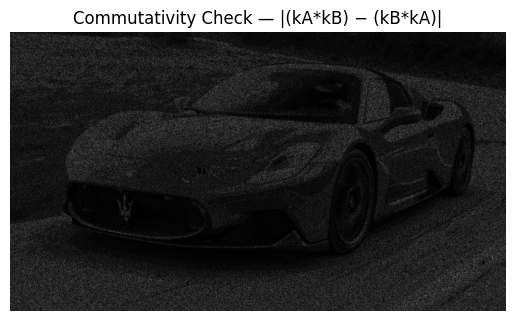

In [25]:
# Use two kernels: box3 and gauss_sigma1
kA = box_kernel(3)
kB = gaussian_kernel_2d(1.0)

A_then_B = conv2d_manual(conv2d_manual(im, kA, border=BORDER), kB, border=BORDER)
B_then_A = conv2d_manual(conv2d_manual(im, kB, border=BORDER), kA, border=BORDER)

mae_comm = float(np.mean(np.abs(A_then_B - B_then_A)))
mxd_comm = float(np.max(np.abs(A_then_B - B_then_A)))
print(f"\n[Bonus: Commutativity] MAE={mae_comm:.6f} | Max|diff|={mxd_comm:.6f}")

plt.figure()
plt.imshow(np.abs(A_then_B - B_then_A), cmap="gray")
plt.title("Commutativity Check — |(kA*kB) − (kB*kA)|")
plt.axis("off")
if SAVE_OUTPUTS:
    plt.savefig(os.path.join(OUT_DIR, "commutativity_absdiff.png"), bbox_inches="tight", pad_inches=0)
plt.show()